# Trabalho KDD

Grupo:  
Alan Aguirre  
Leandro Cadó  
Matheus Prola  
Martin Jungblut  

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from IPython.display import display as print_dataframe
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

## Pré-processamento (preliminar)
1. Importe os dados;
2. Os comentários normais estão no arquivo de sufixo _0 e os sarcásticos estão no _1. Concatene ambos para obter apenas um dataframe completo.
3. Há outliers na variável score. Trate-os substituindo pela média dos não outliers da série;
4. Há valores ausentes nas variáveis subreddit e score. Analise os dados e trate da forma que você julgar melhor, usando alguma das técnicas que aprendemos em aula;
5. No dataframe que estamos trabalhando, crie quatro variáveis dummies, conforme abaixo:
    1. comment_wcount: quantidade de palavras contidas na variável comment;
    2. parent_comment_wcount: quantidade de palavras contidas na variável parent_comment;
    3. comment_char: quantidade de caracteres contidas na variável comment;
    4. parent_comment_char: quantidade de caracteres contidas na variável parent_comment.

In [70]:
# importar e concatenar os dados
df = pd.concat([pd.read_csv(__filename__) for __filename__ in ["COMENTARIOS_{}.csv".format(_) for _ in range(0, 2)]])

# corrigir outliers no score
print("Max score is: {}".format(df["score"].max()))

filter_matrix = df["score"] < df["score"].quantile(0.995)
df.loc[np.invert(filter_matrix), "score"] = df[filter_matrix]["score"].median()

print("Max score is: {}".format(df["score"].max()))

Max score is: 9999999.0
Max score is: 150.0


In [71]:
print(len(df))

# removendo nulos
df = df.dropna()

print(len(df))

1010841
1010767


In [72]:
df["comment_wcount"] = df["comment"].str.count(" ") + 1
df["parent_comment_wcount"] = df["parent_comment"].str.count(" ") + 1

df["comment_char"] = df["comment"].str.len()
df["parent_comment_char"] = df["parent_comment"].str.len()

df.head()

,label,comment,author,subreddit,score,date,parent_comment,comment_wcount,parent_comment_wcount,comment_char,parent_comment_char
0,0,NC and NH.,Trumpbart,politics,2.0,2016-10,"Yeah, I get that argument. At this point, I'd ...",3,17,10,80
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4.0,2016-11,The blazers and Mavericks (The wests 5 and 6 s...,14,27,74,134
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3.0,2016-09,They're favored to win.,19,4,121,23
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8.0,2016-10,deadass don't kill my buzz,12,5,60,26
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6.0,2016-12,Yep can confirm I saw the tool they use for th...,7,18,31,85


## Análise de dados (preliminar)


1. Percentualmente, qual o volume de comentários sarcásticos?

In [73]:
print((df[df['label'] == 1]['label'].count() / df['label'].count())*100)

37.03237244587526


2. Qual o autor que mais comenta com sarcasmo?

In [74]:
top_author_sarcasm = df[df['label'] == 1][['author', 'label']].groupby(['author']).count()
print_dataframe(top_author_sarcasm.sort_values(by='label', ascending=False).head(1))

,label
author,
Biffingston,299


3. Percentualmente, ao longo do tempo os comentários sarcásticos tem aumentado ou diminuído? Plote um gráfico de sua preferência para mostrar a evolução.

,sarcasm_comment,normal_comment
date,,
2009,1078,772
2010,2977,2302
2011,6944,5779
2012,14592,12715
2013,34078,29365
2014,52435,53284
2015,39545,22096
2016,222662,248026


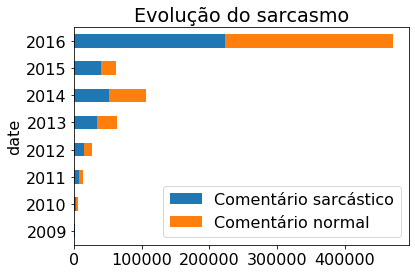

In [75]:
dfPlot = df[['date', 'label']]
dfPlot.loc[:, 'date'] = pd.DatetimeIndex(df['date']).year
dfPlot.loc[:, 'sarcasm_comment'] = np.where(df['label'] == 1, 1, 0)
dfPlot.loc[:, 'normal_comment'] = np.where(df['label'] == 0, 1, 0)

dfPlot = dfPlot[['date', 'sarcasm_comment', 'normal_comment']].groupby(['date']).sum()
print_dataframe(dfPlot)
dfPlot.plot(kind='barh', stacked=True, title='Evolução do sarcasmo', mark_right=True)
plt.legend(['Comentário sarcástico', 'Comentário normal'], loc=4)

4. Percentualmente, olhando a variável subreddit, qual o assunto que mais gera comentários sarcásticos?

In [76]:
top_subreddit = df[['subreddit', 'label']]
top_subreddit.loc[:, 'sarcasm_comment'] = np.where(top_subreddit['label'] == 1, 1, 0)
top_subreddit.loc[:, 'normal_comment'] = np.where(top_subreddit['label'] == 0, 1, 0)
top_subreddit = top_subreddit[['subreddit', 'sarcasm_comment', 'normal_comment']].groupby(['subreddit']).sum()
top_subreddit.loc[:, 'sarcasm_perc'] = (top_subreddit['sarcasm_comment'] / (top_subreddit['sarcasm_comment'] + top_subreddit['normal_comment'])) * 100
print_dataframe(top_subreddit.sort_values(by=['sarcasm_perc', 'sarcasm_comment', 'normal_comment'], ascending=False).head())



,sarcasm_comment,normal_comment,sarcasm_perc
subreddit,,,
riddles,29,0,100.0
security,8,0,100.0
Modern_Family,7,0,100.0
columbiamo,7,0,100.0
AccidentalRacism,5,0,100.0


5. Por tipo de comentário (sarcástico ou não), quantas palavras temos em média em comment_wcount e parent_comment_wcount?

In [77]:
print('sarcástico')
print('comment_wcount')
print(df[df['label'] == 1]['comment_wcount'].mean())
print('parent_comment_wcount')
print(df[df['label'] == 1]['parent_comment_wcount'].mean())
print('---------------------------------------')
print('não sarcástico')
print('comment_wcount')
print(df[df['label'] == 0]['comment_wcount'].mean())
print('parent_comment_wcount')
print(df[df['label'] == 0]['parent_comment_wcount'].mean())


sarcástico
comment_wcount
10.30922949098477
parent_comment_wcount
24.175714846745088
---------------------------------------
não sarcástico
comment_wcount
10.604072778951698
parent_comment_wcount
24.566772364087097


6. Comentários sarcásticos são maiores ou menores em relação aos comentários normais? Use o campo comment_char criado anteriormente para mostrar essa relação através de gráficos de distribuição.

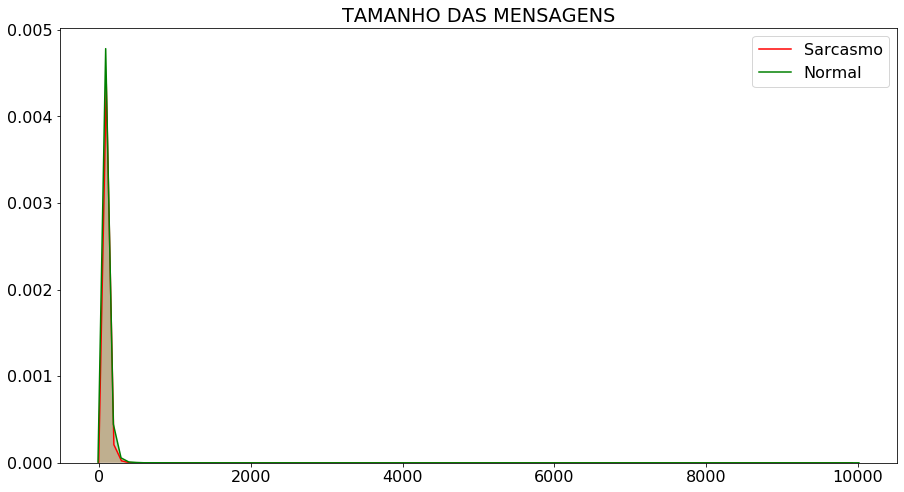

In [78]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15,8))
sns.kdeplot(df[df['label'] == 1]['comment_char'], shade=True,label='Sarcasmo', color='r').set_title('TAMANHO DAS MENSAGENS')
sns.kdeplot(df[df['label'] == 0]['comment_char'], shade=True, label='Normal', color='g')

7. Se uníssimos comment e parent_comment em uma só mensagem, percentualmente em média, quanto representaria comment em relação a mensagem unida. Utilize os campos comment_char e parent_comment_char que criamos anteriormente.

In [79]:
dfMsg = df[['comment_char', 'parent_comment_char']]
dfMsg.loc[:, 'comment_perc'] = (dfMsg['comment_char'] / (dfMsg['comment_char'] + dfMsg['parent_comment_char'])) * 100

print('A média é:')
print(dfMsg['comment_perc'].mean())

A média é:
38.421061444788776


In [96]:
df.shape

(1010767, 11)

## Pré-processamento para mineração de texto
Aqui a ideia é aplicarmos o pipeline que aprendemos em aula:
1. Crie uma função que faça as transformações necessárias no texto:
    1. Retire pontuações
    2. Remova stopwords
    3. Normalize no seu sentido mais abstrato (stemming)
2. Vetorize a mensagem por Word Count e aplique a função de transformação criada no passo anterior;
3. Transforme a matriz verotizada de WC em um dataframe e inclua o campo label;
4. Vetorize novamente os dados só que agora aplicando a equação TF-IDF;
5. Transforme a matriz esparsa verotizada de TF-IDF em um dataframe e inclua o campo label;
6. Qual o top 10 palavras com maiores valores de TF-IDF (em relação a todo o corpus)?

In [83]:
wordcount_vetorizer = CountVectorizer(stop_words='english', lowercase=True, max_features=3000).fit(df['comment'])

In [84]:
wordcount_vetorized = wordcount_vetorizer.transform(df['comment'])

In [85]:
wordcount_vetorized.shape

(1010767, 3000)

In [94]:
wordcount_vetorizer.get_feature_names()

['000',
 '10',
 '100',
 '1000',
 '1080',
 '11',
 '12',
 '13',
 '14',
 '15',
 '150',
 '16',
 '17',
 '18',
 '19',
 '1st',
 '20',
 '200',
 '2000',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '21',
 '22',
 '24',
 '25',
 '2nd',
 '30',
 '300',
 '35',
 '360',
 '3d',
 '3rd',
 '40',
 '400',
 '45',
 '4chan',
 '4k',
 '4th',
 '50',
 '500',
 '60',
 '70',
 '75',
 '80',
 '90',
 '99',
 'ability',
 'able',
 'abortion',
 'absolute',
 'absolutely',
 'abuse',
 'accent',
 'accept',
 'acceptable',
 'accepted',
 'access',
 'accident',
 'accidentally',
 'according',
 'account',
 'accounts',
 'accurate',
 'act',
 'acting',
 'action',
 'actions',
 'active',
 'actual',
 'actually',
 'ad',
 'adam',
 'adc',
 'add',
 'added',
 'adding',
 'address',
 'adds',
 'admit',
 'ads',
 'adult',
 'adults',
 'advanced',
 'advantage',
 'advertising',
 'advice',
 'af',
 'affect',
 'afford',
 'afraid',
 'africa',
 'african',
 'age',
 'agenda',
 'agent',
 'aggressive',
 'ago',
 'agree',
 'agreed',
 'ah',
 'ahead',
 'ahh',
 'ai',

In [93]:
ml_df = pd.DataFrame(wordcount_vetorized.todense(), columns=wordcount_vetorizer.get_feature_names())

MemoryError: 

In [46]:
print(ml_df.head(20))
print(ml_df.shape)
print(df['label'].shape)

   label   00  000   10  100  1000   11   12  120   13  ...  yesterday   yo  \
0      0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...        0.0  0.0   
1      0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...        0.0  0.0   
2      0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...        0.0  0.0   
3      0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...        0.0  0.0   
4      0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...        0.0  0.0   
5      0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...        0.0  0.0   
6      0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...        0.0  0.0   
7      0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...        0.0  0.0   
8      0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...        0.0  0.0   
9      0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...        0.0  0.0   
10     0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...        0.0  0.0   
11     0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0

In [ ]:
ml_df = pd.concat([df['label'], ml_df], axis=1)
ml_df = ml_df.dropna()

In [ ]:
tfidf_vetorizer = TfidfTransformer().fit(wordcount_vetorized)

In [ ]:
tfidf_df = pd.DataFrame(
    tfidf_vetorizer.transform(wordcount_vetorized).todense(),
    columns=wordcount_vetorizer.get_feature_names()
)

In [ ]:
tfidf_df = pd.concat([df['label'], tfidf_df], axis=1)
tfidf_df = tfidf_df.dropna()
tfidf_df.head()

In [ ]:
# display TF-IDF ranked words
pd.DataFrame(tfidf_vetorizer.idf_, index=wordcount_vetorizer.get_feature_names(), columns=['TF-IDF']).sort_values(by=['TF-IDF'], ascending = False).head(10)

## Mineração de texto
Nosso objetivo é criar um modelo supervisionado que identifique se a mensagem é ou não sarcástica.
1. Escolha pelo menos dois algoritmos de classificação (pesquise na comunidade quais técnicas são mais indicadas para text mining).
2. Para cada algoritmo, treine um modelo utilizando a matriz vetorizada WC e faça o mesmo com a matriz TF-IDF, compare os resultados.

In [ ]:
ml_df['label'] = ml_df['label'].astype(int)
tfidf_df['label'] = tfidf_df['label'].astype(int)

In [26]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(tfidf_df.drop('label', axis=1),tfidf_df['label'],test_size=0.3)

In [27]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  100.0


In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

In [ ]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(ml_df.drop('label', axis=1),ml_df['label'],test_size=0.3)

In [ ]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)